In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import LabelEncoder



In [2]:
# Parameters
input_size = (224, 224)
batch_size = 32
num_classes = 6  # Number of sentiment classes
epochs = 50  # Adjust as needed



In [3]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [4]:
# Define a function to preprocess the dataset
def preprocess_dataset(dataset_dir):
    data = []
    labels = []
    for emotion_label in os.listdir(dataset_dir):
        emotion_dir = os.path.join(dataset_dir, emotion_label)
        if os.path.isdir(emotion_dir):
            for root, dirs, files in os.walk(emotion_dir):
                for image_file in files:
                    image_path = os.path.join(root, image_file)
                    image = load_img(image_path, target_size=input_size)
                    image = img_to_array(image)
                    
                    # Check if it's a color image (3 channels) or grayscale
                    if image.shape[-1] == 3:
                        data.append(image)
                    else:
                        # Apply histogram equalization to grayscale images
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image = cv2.equalizeHist(image)
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                        data.append(image)

                    labels.append(emotion_label)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    return np.array(data), labels



In [5]:
from sklearn.model_selection import train_test_split
# Define the path to your dataset
dataset_dir = 'D:/Study/Digital Image Processing/Dataset/UnBiasedEmo/images'

# Preprocess the entire dataset
X, y = preprocess_dataset(dataset_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

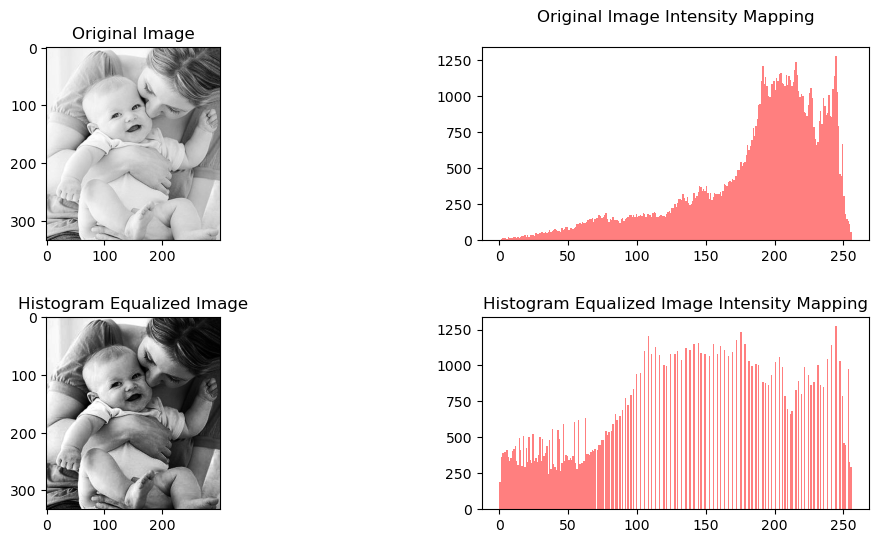

In [6]:
import cv2
import matplotlib.pyplot as plt

# Load the original image
img_path = 'D:/Study/Digital Image Processing/Dataset/UnBiasedEmo/images/love/baby/0.jpg'
original_image = cv2.imread(img_path)

# Convert the image to grayscale if it's a color image
if original_image.shape[-1] == 3:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(original_image)

# Plot the intensity mapping histograms
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.hist(original_image.ravel(), bins=256, range=[0, 256], color='r', alpha=0.5)
plt.title('Original Image Intensity Mapping\n')

# Histogram Equalized Image
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Histogram Equalized Image')

plt.subplot(2, 2, 4)
plt.hist(equalized_image.ravel(), bins=256, range=[0, 256], color='r', alpha=0.5)
plt.title('Histogram Equalized Image Intensity Mapping')


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [7]:
import joblib
from sklearn.preprocessing import LabelEncoder


# Convert one-hot encoded labels to 1D labels
y_train_labels = [np.argmax(label) for label in y_train]

# Fit the LabelEncoder to the training labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)

# Save the fitted LabelEncoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [8]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.constraints import max_norm
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_size + (3,))
densenet_base = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_size + (3,))

# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, dropout_rate=0.5,l2_penalty=0.01):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty), kernel_constraint=max_norm(3))(x
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)  # Add dropout layer
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Usage with dropout
vgg_model_with_dropout = create_transfer_model_with_dropout(vgg_base,l2_penalty=0.01)
resnet_model_with_dropout = create_transfer_model_with_dropout(resnet_base,l2_penalty=0.01)
densenet_model_with_dropout = create_transfer_model_with_dropout(densenet_base,l2_penalty=0.01)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg_model_with_dropout)
compile_model(resnet_model_with_dropout)
compile_model(densenet_model_with_dropout)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the models
vgg_history_with_dropout = vgg_model_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen,callbacks=[early_stopping])
resnet_history_with_dropout = resnet_model_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen,callbacks=[early_stopping])
densenet_history_with_dropout = densenet_model_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen,callbacks=[early_stopping])


Epoch 1/50
77/77 [==============================] - 1333s 17s/step - loss: 8.2039 - accuracy: 0.2315 - val_loss: 7.6253 - val_accuracy: 0.2233
Epoch 2/50
77/77 [==============================] - 1335s 17s/step - loss: 7.1004 - accuracy: 0.2705 - val_loss: 6.5785 - val_accuracy: 0.2972
Epoch 3/50
77/77 [==============================] - 1063s 14s/step - loss: 6.1222 - accuracy: 0.3087 - val_loss: 5.6886 - val_accuracy: 0.2923
Epoch 4/50
77/77 [==============================] - 1081s 14s/step - loss: 5.3116 - accuracy: 0.3165 - val_loss: 4.9495 - val_accuracy: 0.3153
Epoch 5/50
77/77 [==============================] - 1309s 17s/step - loss: 4.6126 - accuracy: 0.3424 - val_loss: 4.3142 - val_accuracy: 0.3563
Epoch 6/50
77/77 [==============================] - 1306s 17s/step - loss: 4.0588 - accuracy: 0.3567 - val_loss: 3.8396 - val_accuracy: 0.3432
Epoch 7/50
77/77 [==============================] - 1307s 17s/step - loss: 3.6142 - accuracy: 0.3621 - val_loss: 3.4247 - val_accuracy: 0.3612

77/77 [==============================] - 656s 9s/step - loss: 1.8191 - accuracy: 0.9635 - val_loss: 3.1684 - val_accuracy: 0.6404
Epoch 18/50
77/77 [==============================] - 653s 8s/step - loss: 1.6389 - accuracy: 0.9524 - val_loss: 2.7740 - val_accuracy: 0.6732
Epoch 19/50
77/77 [==============================] - 625s 8s/step - loss: 1.4418 - accuracy: 0.9520 - val_loss: 2.3214 - val_accuracy: 0.7110
Epoch 20/50
77/77 [==============================] - 466s 6s/step - loss: 1.2365 - accuracy: 0.9700 - val_loss: 2.6218 - val_accuracy: 0.6305
Epoch 21/50
77/77 [==============================] - 726s 9s/step - loss: 1.1719 - accuracy: 0.9417 - val_loss: 2.4045 - val_accuracy: 0.6355
Epoch 22/50
77/77 [==============================] - 728s 9s/step - loss: 0.9683 - accuracy: 0.9655 - val_loss: 2.1988 - val_accuracy: 0.6979
Epoch 23/50
77/77 [==============================] - 725s 9s/step - loss: 0.8677 - accuracy: 0.9647 - val_loss: 1.9715 - val_accuracy: 0.6880
Epoch 24/50
77/77 

In [ ]:
vgg_model_with_dropout.summary()

In [ ]:
vgg_base.summary()

In [ ]:
vgg_train_loss = vgg_history_with_dropout.history['loss']
vgg_val_loss = vgg_history_with_dropout.history['val_loss']
vgg_train_acc = vgg_history_with_dropout.history['accuracy']
vgg_val_acc = vgg_history_with_dropout.history['val_accuracy']

resnet_train_loss = resnet_history_with_dropout.history['loss']
resnet_val_loss = resnet_history_with_dropout.history['val_loss']
resnet_train_acc = resnet_history_with_dropout.history['accuracy']
resnet_val_acc = resnet_history_with_dropout.history['val_accuracy']

densenet_train_loss = densenet_history_with_dropout.history['loss']
densenet_val_loss = densenet_history_with_dropout.history['val_loss']
densenet_train_acc = densenet_history_with_dropout.history['accuracy']
densenet_val_acc = densenet_history_with_dropout.history['val_accuracy']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_train_loss, label='VGG19 Training Loss')
plt.plot(vgg_val_loss, label='VGG19 Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG19 Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(vgg_train_acc, label='VGG19 Training Accuracy')
plt.plot(vgg_val_acc, label='VGG19 Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG19 Accuracy Over Time')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resnet_train_loss, label='Resnet Training Loss')
plt.plot(resnet_val_loss, label='Resnet Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Resnet Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(resnet_train_acc, label='Resnet Training Accuracy')
plt.plot(resnet_val_acc, label='Resnet Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Resnet Accuracy Over Time')

plt.show()


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(densenet_train_loss, label='Densenet Training Loss')
plt.plot(densenet_val_loss, label='Densenet Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Densenet Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(densenet_train_acc, label='Densenet Training Accuracy')
plt.plot(densenet_val_acc, label='Densenet Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Densenet Accuracy Over Time')

plt.show()


In [ ]:
# Save the VGG19 model
vgg_model_with_dropout.save('vgg19_emotion_model.h5')

# Save the ResNet-50 model
resnet_model_with_dropout.save('resnet50_emotion_model.h5')

# Save the DenseNet model
densenet_model_with_dropout.save('densenet122_emotion_model.h5')


In [ ]:
# Calculate and print accuracy for each model
vgg_accuracy = vgg_history_with_dropout.history['accuracy'][-1]
resnet_accuracy = resnet_history_with_dropout.history['accuracy'][-1]
densenet_accuracy = densenet_history_with_dropout.history['accuracy'][-1]

print(f'VGG19 Accuracy: {vgg_accuracy * 100:.2f}%')
print(f'ResNet-50 Accuracy: {resnet_accuracy * 100:.2f}%')
print(f'DenseNet Accuracy: {densenet_accuracy * 100:.2f}%')


In [ ]:
vgg_test_accuracy = vgg_model_with_dropout.evaluate(test_datagen)[1]
resnet_test_accuracy = resnet_model_with_dropout.evaluate(test_datagen)[1]
densenet_test_accuracy = densenet_model_with_dropout.evaluate(test_datagen)[1]

print(f'VGG19 Test Accuracy: {vgg_test_accuracy * 100:.2f}%')
print(f'ResNet-50 Test Accuracy: {resnet_test_accuracy * 100:.2f}%')
print(f'DenseNet Test Accuracy: {densenet_test_accuracy * 100:.2f}%')


In [ ]:
encoded_classes = encoder.classes_
print(encoded_classes)

# K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np


In [ ]:
k = 3  # You can adjust the number of folds as needed
vgg_accuracies = []
resnet_accuracies = []
densenet_accuracies = []


In [ ]:
kf = KFold(n_splits=k, shuffle=True, random_state=42)


In [ ]:
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    vgg_model = create_transfer_model_with_dropout(vgg_base)
    resnet_model = create_transfer_model_with_dropout(resnet_base)
    densenet_model = create_transfer_model_with_dropout(densenet_base)
    
    compile_model(vgg_model)
    compile_model(resnet_model)
    compile_model(densenet_model)
    
    train_datagen = datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size)
    
    vgg_history = vgg_model.fit(train_datagen, epochs=epochs, validation_data=(X_val_fold, y_val_fold),callbacks=[early_stopping])
    resnet_history = resnet_model.fit(train_datagen, epochs=epochs, validation_data=(X_val_fold, y_val_fold),callbacks=[early_stopping])
    densenet_history = densenet_model.fit(train_datagen, epochs=epochs, validation_data=(X_val_fold, y_val_fold),callbacks=[early_stopping])
    
    vgg_accuracies.append(vgg_history.history['val_accuracy'][-1])
    resnet_accuracies.append(resnet_history.history['val_accuracy'][-1])
    densenet_accuracies.append(densenet_history.history['val_accuracy'][-1])


In [ ]:
print(f"VGG19 Cross-Validation Mean Accuracy: {np.mean(vgg_accuracies) * 100:.2f}%")
print(f"VGG19 Cross-Validation Accuracy Std. Deviation: {np.std(vgg_accuracies) * 100:.2f}%")

print(f"ResNet-50 Cross-Validation Mean Accuracy: {np.mean(resnet_accuracies) * 100:.2f}%")
print(f"ResNet-50 Cross-Validation Accuracy Std. Deviation: {np.std(resnet_accuracies) * 100:.2f}%")

print(f"DenseNet Cross-Validation Mean Accuracy: {np.mean(densenet_accuracies) * 100:.2f}%")
print(f"DenseNet Cross-Validation Accuracy Std. Deviation: {np.std(densenet_accuracies) * 100:.2f}%")


In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(vgg_model_with_dropout,to_file='model.png',show_shapes=True,show_layer_names=True)
Image(filename='model.png')

# Prediction in new Data

In [ ]:
encoded_classes = encoder.classes_
print(encoded_classes)

In [ ]:
# List of emotion labels
emotion_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# Example: Predict the emotion of a new image
new_image_path = 'C:/Users/Jaher - ADM/Downloads/Ashik.jpg'
new_image = load_img(new_image_path, target_size=input_size)
new_image = img_to_array(new_image)
new_image = new_image.reshape((1,) + new_image.shape)
#predicted_emotion_vgg = vgg_model.predict(new_image)
predicted_emotion_resnet = resnet_model.predict(new_image)
predicted_emotion_densenet = densenet_model.predict(new_image)

# Get the predicted emotion label
#predicted_label_vgg = emotion_labels[np.argmax(predicted_emotion_vgg)]
predicted_label_resnet = emotion_labels[np.argmax(predicted_emotion_resnet)]
predicted_label_densenet = emotion_labels[np.argmax(predicted_emotion_densenet)]

# Display the image with the predicted emotion
plt.imshow(load_img(new_image_path))
#plt.title(f'Predicted Emotion (VGG): {predicted_label_vgg}\nPredicted Emotion (ResNet): {predicted_label_resnet}\nPredicted Emotion (DenseNet): {predicted_label_densenet}')
plt.title(f'Predicted Emotion (ResNet): {predicted_label_resnet}\nPredicted Emotion (DenseNet): {predicted_label_densenet}')
plt.show()

In [ ]:
# Load the saved models
from tensorflow.keras.models import load_model

# Load the VGG19 model
vgg_model = load_model('vgg19_emotion_model.h5')

# Load the ResNet-50 model
resnet_model = load_model('resnet50_emotion_model.h5')

# Load the DenseNet model
densenet_model = load_model('densenet122_emotion_model.h5')

# Evaluate the models on the test data
vgg_evaluation = vgg_model.evaluate(X_test, y_test)
resnet_evaluation = resnet_model.evaluate(X_test, y_test)
densenet_evaluation = densenet_model.evaluate(X_test, y_test)

# Print the evaluation results
print("VGG19 Evaluation:")
print("Test Loss:", vgg_evaluation[0])
print("Test Accuracy:", vgg_evaluation[1])

print("\nResNet-50 Evaluation:")
print("Test Loss:", resnet_evaluation[0])
print("Test Accuracy:", resnet_evaluation[1])

print("\nDenseNet Evaluation:")
print("Test Loss:", densenet_evaluation[0])
print("Test Accuracy:", densenet_evaluation[1])


# Without the Transfer Learning

In [ ]:
from tensorflow.keras.optimizers import Adam

# Load base models
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_size + (3,))
densenet_base = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_size + (3,))

# Compile base models with dropout
def compile_base_model_with_dropout(base_model, dropout_rate=0.5):
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),  # Add dropout layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Compile base models with dropout
vgg_base_with_dropout = compile_base_model_with_dropout(vgg_base)
resnet_base_with_dropout = compile_base_model_with_dropout(resnet_base)
densenet_base_with_dropout = compile_base_model_with_dropout(densenet_base)

# Data generators for training and testing
train_datagen = datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)  # Assuming y_train_one_hot is one-hot encoded
test_datagen = datagen.flow(X_test, y_test_one_hot, batch_size=batch_size)     # Assuming y_test_one_hot is one-hot encoded

# Train the models with dropout
vgg_base_history_with_dropout = vgg_base_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen, callbacks=[early_stopping])
resnet_base_history_with_dropout = resnet_base_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen, callbacks=[early_stopping])
densenet_base_history_with_dropout = densenet_base_with_dropout.fit(train_datagen, epochs=50, validation_data=test_datagen, callbacks=[early_stopping])


In [ ]:
vgg_base_train_loss = vgg_base_history_with_dropout.history['loss']
vgg_base_val_loss = vgg_base_history_with_dropout.history['val_loss']
vgg_base_train_acc = vgg_base_history_with_dropout.history['accuracy']
vgg_base_val_acc = vgg_base_history_with_dropout.history['val_accuracy']

resnet_base_train_loss = resnet_base_history_with_dropout.history['loss']
resnet_base_val_loss = resnet_base_history_with_dropout.history['val_loss']
resnet_base_train_acc = resnet_base_history_with_dropout.history['accuracy']
resnet_base_val_acc = resnet_base_history_with_dropout.history['val_accuracy']

densenet_base_train_loss = densenet_base_history_with_dropout.history['loss']
densenet_base_val_loss = densenet_base_history_with_dropout.history['val_loss']
densenet_base_train_acc = densenet_base_history_with_dropout.history['accuracy']
densenet_base_val_acc = densenet_base_history_with_dropout.history['val_accuracy']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_base_train_loss, label='VGG19 Training Loss')
plt.plot(vgg_base_val_loss, label='VGG19 Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG19 Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(vgg_base_train_acc, label='VGG19 Training Accuracy')
plt.plot(vgg_base_val_acc, label='VGG19 Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG19 Accuracy Over Time')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resnet_base_train_loss, label='Resnet Training Loss')
plt.plot(resnet_base_val_loss, label='Resnet Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Resnet Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(resnet_base_train_acc, label='Resnet Training Accuracy')
plt.plot(resnet_base_val_acc, label='Resnet Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Resnet Accuracy Over Time')

plt.show()


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(densenet_base_train_loss, label='Densenet Training Loss')
plt.plot(densenet_base_val_loss, label='Densenet Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Densenet Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(densenet_base_train_acc, label='Densenet Training Accuracy')
plt.plot(densenet_base_val_acc, label='Densenet Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Densenet Accuracy Over Time')

plt.show()


In [ ]:
# Calculate and print accuracy for each model
vgg_accuracy = vgg_base_history_with_dropout.history['accuracy'][-1]
resnet_accuracy = resnet_base_history_with_dropout.history['accuracy'][-1]
densenet_accuracy = densenet_base_history_with_dropout.history['accuracy'][-1]

print(f'VGG19 Accuracy: {vgg_accuracy * 100:.2f}%')
print(f'ResNet-50 Accuracy: {resnet_accuracy * 100:.2f}%')
print(f'DenseNet Accuracy: {densenet_accuracy * 100:.2f}%')


In [ ]:
# Save the VGG19 model
vgg_base_with_dropout.save('vgg19_base_emotion_model.h5')

# Save the ResNet-50 model
resnet_base_with_dropout.save('resnet50_base_emotion_model.h5')

# Save the DenseNet model
densenet_base_with_dropout.save('densenet122_base_emotion_model.h5')


In [ ]:
# List of emotion labels
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

# Example: Predict the emotion of a new image
new_image_path = 'C:/Users/Jaher - ADM/Downloads/Ashik.jpg'
new_image = load_img(new_image_path, target_size=input_size)
new_image = img_to_array(new_image)
new_image = new_image.reshape((1,) + new_image.shape)
predicted_emotion_vgg = vgg_base_with_dropout.predict(new_image)
predicted_emotion_resnet = resnet_base_with_dropout.predict(new_image)
predicted_emotion_densenet = densenet_base_with_dropout.predict(new_image)

# Get the predicted emotion label
predicted_label_vgg = emotion_labels[np.argmax(predicted_emotion_vgg)]
predicted_label_resnet = emotion_labels[np.argmax(predicted_emotion_resnet)]
predicted_label_densenet = emotion_labels[np.argmax(predicted_emotion_densenet)]

# Display the image with the predicted emotion
plt.imshow(load_img(new_image_path))
plt.title(f'Predicted Emotion (VGG): {predicted_label_vgg}\nPredicted Emotion (ResNet): {predicted_label_resnet}\nPredicted Emotion (DenseNet): {predicted_label_densenet}')
plt.show()